# Claro loop + fit

In [1]:
#!/usr/bin/env python

# %matplotlib # namespace not used for now

import os
import re
import csv
import time
import fnmatch
import numpy as np
import pandas as pd
import matplotlib as mplt
import matplotlib.pyplot as plt
from scipy import special as sp
from scipy.optimize import curve_fit

In [2]:
def fileinfo(TDIR, DIRPATH="*Station_1__*\Station_1__??_Summary\Chip_*\S_curve",
               FILEPATH="Ch_*_offset_*_Chip_*.txt"):
    """
    Function that walks on all subdirectories of TDIR that match DIRPATH and FILEPATH.
    Returns a dict with the following keys extracted from the files:
    - path
    - station
    - sub
    - chip
    - ch
    - offset
    - amplitude 
    - transition
    - width
    """
    # Returns processing time as well.
    start_time = time.time()
    
    #################### To limit the function on 1 folder only############################
    DIRPATH    = "*Station_1__11\Station_1__??_Summary\Chip_001\S_curve"
    #######################################################################################
    
    if isinstance(TDIR, str)==False:
        raise NameError('Please provide a string with delimiter: double backslash (\\\) as top directory path.')

    enter = input(f'The default subfolders\' paths are {DIRPATH}.\n'
                    +f'The default file names are {FILEPATH}.\n'
                    +f'To confirm, press Enter. Press any other key to change the paths.\n')
    if enter != '':
        DIRPATH  = input('Please provide subfolders\' paths. You may use wildcards.\n')
        FILEPATH = input('Please provide file names. You may use wildcards.\n')
    
    OUTFILE = "claro_files.txt"
    OUTBAD  = 'bad_files.txt'
    fileinfos = dict()
    
    for root, dirs, files in os.walk(TDIR):
        if fnmatch.fnmatch(
            root, TDIR + DIRPATH):
            for f in files:
                if fnmatch.fnmatch(f, FILEPATH):
                    thisfile = os.path.join(root,f)
                            # path of file currently used
                    with open(thisfile) as csvfile:
                        lines = csvfile.readlines()
                        firstline = lines[0].split()
                        try:
                            if isinstance(float(firstline[2]), float):
                                temp = re.findall("[0-9]+", thisfile)
                                fileinfos[thisfile] = {
                                        'path' : thisfile,
                                        'station': temp[0],
                                        'sub': temp[2],
                                        'chip': temp[5],
                                        'ch': temp[6],
                                        'offset': temp[7],
                                        'amplitude': float(firstline[0]),
                                        'transition': float(firstline[1]),
                                        'width': float(firstline[2]),
                                        }
                            with open(OUTFILE, "w+") as output:
                                output.write(thisfile+"\n")
                        except ValueError:
                            print(f"ValueError: Couldn't read data in: {thisfile}\n "
                                 + "Going on...")
                            with open(OUTBAD, "w+") as output:
                                output.write(thisfile+"\n")
                            pass
                        except IndexError:
                            raise
    
    print("Process completed in %s s." % (format(time.time()-start_time,".2f")))
    print(f"Output paths to good files are stored in {OUTFILE}")
    print(f"Output paths to bad files are stored in {OUTBAD}")
    
    return fileinfos

In [3]:
def read_data(path):
    data = pd.read_csv(path, sep='\t', header=None, skiprows=None)
    x = data.iloc[2:,0].to_numpy()
    y = data.iloc[2:,1].to_numpy()
    AMPLITUDE = data.iloc[0,0]
    TRANSITION = data.iloc[0,1]
    WIDTH = -data.iloc[0,2]
    META = {
        'amplitude' : AMPLITUDE,
        'transition' : TRANSITION,
        'width' : WIDTH
    }
    return x, y, META

In [4]:
def func(x, ampl, a, b):
    """
    Modified erf function with amplitude ampl and shift on the vertical axis ampl/2,
    inflection point at a, normalization proportional to b.
    Guesses may be provide as a list e.g. [AMPLITUDE, TRANSITION, AMPLITUDE/2].
    """
    return ampl/2*(1+sp.erf((x-a)/(b*np.sqrt(2))))

def fit_erf(x, y, META, npoints=1000):
    
    # Fit part: curve_fit returns best fit parameters and covariance matrix
    # Coviariance matrix contains variance of best fit parameters on main diagonal
    GUESSES = [META['amplitude'], META['transition'], META['amplitude']/2]
    fit_params, fit_covar = curve_fit(func, x, y, p0=GUESSES)
    fit_dev = np.sqrt(np.diag(fit_covar))
    
    metafit = {
        'params' : [fit_params[0], fit_params[1], fit_params[2]], #[amplitude, transition, width/2]
        'errors' : [fit_dev[0], fit_dev[1], fit_dev[2]],
    }
    
    return metafit

In [42]:
# Use annotate() to create annotation (text) on the plot for parameters provided by the fit and
# parameters provided by the file

FORMAT = 'png'
SAVEPATH = '.\plot'+'.'+f'{FORMAT}'

def plot_fit(x, y, metafit, fileinfo, npoints=1000,
             show_scatter=True, show_fit=True, show_transition=True,
             save=False, show=True,
             **kwargs):
    """
    [Function documentation]
    """
    
    font = {
        'fontsize': 5, # rcParams['axes.titlesize'],
        'fontweight' : plt.rcParams['axes.titleweight'],
        'verticalalignment': 'baseline',
        # 'horizontalalignment': plt.loc,
    }
    
    plt.figure(figsize=(3.5, 3.5), dpi=300, tight_layout=True)
    plt.title(f"Fit CLARO: station {fileinfo['station']}, chip {fileinfo['chip']}, ch {fileinfo['ch']}",
              fontdict=font)

    # x,y data computed as a grid of npoints and using parameters of the fit
    fit_params = metafit['params']
    fit_errs = metafit['errors']
    
    xfit = np.linspace(x.min(), x.max(), npoints)
    yfit= func(xfit, *fit_params)
    
    # Show scatterplot of data (default = True)
    if show_scatter == True:
        plt.scatter(x, y, label='Data points', zorder=2)
        plt.annotate(f"From data file\nTransition = {fileinfo['transition']:.2f}\n"
                     +f"Width = {fileinfo['width']:.2f}",
             xy=(0.025, .975), xycoords='axes fraction', verticalalignment='top', color='gray', alpha=0.5)
    
    # Show plot of fit (default = True)
    if show_fit == True: 
        plt.plot(xfit, yfit, label='erf fit', zorder=1, color='r', alpha=0.8)
        plt.annotate(f"Fit parameters\nAmplitude = ({fit_params[0]:.2f}"+r" $\pm$ "+f"{fit_errs[0]:.2f})\n"
                     +f"Transition = ({fit_params[1]:.2f}"+r" $\pm$ "+f"{fit_errs[1]:.2E})\n"
                     +f"Width = ({fit_params[2]*2:.2f}"+r" $\pm$ "+f"{fit_errs[2]*2:.2E})",
                     xy=(0.025, .3), xycoords='axes fraction', verticalalignment='top',
                     color='r', alpha=0.5,
                     bbox=dict(boxstyle="square", fc="white", ec="black", lw=1, alpha=0.5))
        
    # Show transition point
    if show_transition == True:
        xtrans = fit_params[1]
        ytrans = func(xtrans, *fit_params)
        plt.scatter(xtrans, ytrans, s=100, c='darkred', marker='*',
                    zorder=2, label='Transition point')
        plt.vlines(x=xtrans, ymin=y[0], ymax=y[-1], linestyles='dashed',
                   alpha=0.5, zorder=1)
        plt.hlines(y=ytrans, xmin=x[0], xmax=x[-1], linestyles='dashed',
                   alpha=0.5, zorder=1)
        plt.annotate(f"Transition = {fit_params[1]:.2f}\nWidth = {fit_params[2]*2:.2f}", 
                     xy=(0.025, .6), xycoords='axes fraction', verticalalignment='top',)

    
    plt.xlabel('x [arb units]', fontdict=font)
    plt.ylabel('y [arb units]', fontdict=font)
    # plt.legend(loc='lower right', fontsize = 8)
    
    if save == True:
        plt.savefig(f'{SAVEPATH}')
    
    if show == True:
        plt.show()

In [7]:
a = fileinfo('C:\\Users\\MARTINA\\Desktop\\secondolotto_1\\')

The default subfolders' paths are *Station_1__11\Station_1__??_Summary\Chip_001\S_curve.
The default file names are Ch_*_offset_*_Chip_*.txt.
To confirm, press Enter. Press any other key to change the paths.
 


ValueError: Couldn't read data in: C:\Users\MARTINA\Desktop\secondolotto_1\Station_1__11\Station_1__11_Summary\Chip_001\S_curve\Ch_8_offset_0_Chip_001.txt
 Going on...
Process completed in 24.80 s.
Output paths to good files are stored in claro_files.txt
Output paths to bad files are stored in bad_files.txt


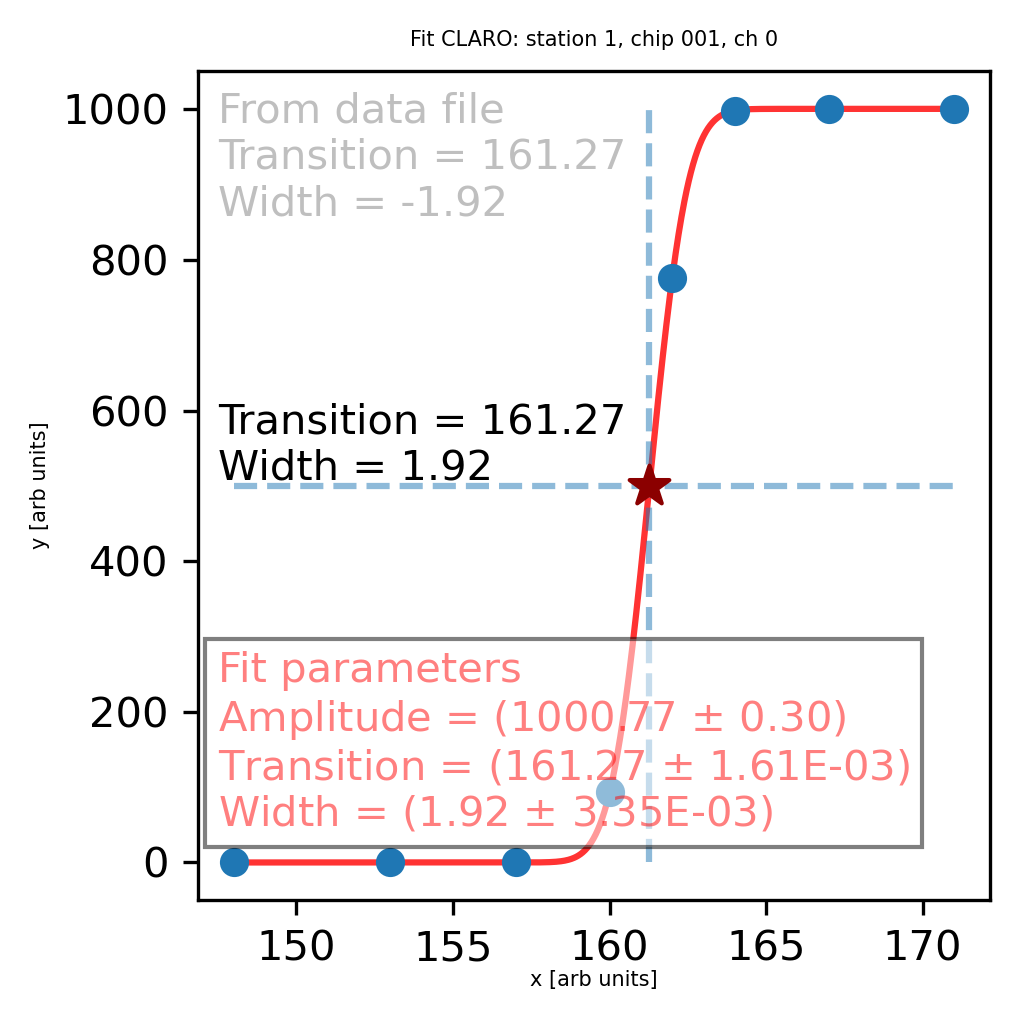

In [43]:
for file in a.values(): # file is the sub-dict, access keys via file['key']
    x,y,meta = read_data(file['path'])
    metafit = fit_erf(x,y,meta)
    plot_fit(x, y, metafit, fileinfo=file, )
    break